Primeiramente importamos uns módulos útiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import special
from mpl_toolkits.mplot3d import Axes3D
import time as time
from matplotlib import path
from matplotlib.path import Path
from tqdm import tqdm
import matlab.engine

t0 = time.perf_counter()

Inicializamos parámetros básicos.

In [2]:
boundary = 'EU'
a = 10

max_in_sum_1 = 50 # Puntos para cada orde.
max_in_sum_2 = 50 # Ordes de F_n.

M = 1
N = 1

spacing_subarray = 0.5
spacing_dipoles = 0.5

Decidimos se calculamos as táboas.

In [3]:
Table_F = False
Table_K = False

Element = True
Subarray = True

Definimos unha función para determinar puntos dentro e fóra da máscara e o seu raio.

In [4]:
def pass_to_dB(function):
    return 10 * np.log10(function / np.max(function))

def clear_around(function, limit):
    function[np.where(function < limit)] = limit
    #function[out_arg] = limit

def degrees(angle):
    return 180 * angle / np.pi

def radians(angle):
    return np.pi * angle / 180

def _ancho_(phi_rad_0):
    theta = 0
    
    for i in np.arange(1, 5): # Calculamos o ancho exacto a -0.50 dB.
        step = 10 / 8**i
        temp = 1
        
        while temp > 0:
            theta += step
            u = np.sin(radians(theta)) * np.cos(phi_rad_0)
            v = np.sin(radians(theta)) * np.sin(phi_rad_0)
            temp = mask_path.contains_point((u, v)) * 1 # 1 se o contén, 0 se non.
        
        theta -= step
    return np.sin(radians(theta))

def track_radio_mask(radio_0, sin_theta_0, mask, phi_rad):
    sin_theta_vector = np.zeros(len(phi_rad))
    
    for i in range(len(phi_rad)):
        sin_theta_vector[i] = _ancho_(phi_rad[i])
    
    return radio_0 * sin_theta_0 / sin_theta_vector

Procedemos ao cálculos coa máscara.

In [5]:
mask = np.loadtxt('Masks/mask_boundary_'+ boundary + '.dat')
mask_path = Path((mask))

radio_0 = 50 # Radio de 50 lambda.
sin_theta_0 = 0.04273

phi_deg = np.arange(-180, 180 + 0.1, 0.1)
phi_rad = np.pi * phi_deg / 180
radio_vector = track_radio_mask(radio_0, sin_theta_0, mask, phi_rad) # Creamos o vector radio.

Gardamos o raio vector para acceder a el dende Matlab.

In [6]:
np.savetxt('Temporal_radial_vector.txt', np.column_stack(radio_vector) / radio_0)

## Zeros de Bessel

In [7]:
rows = 2 * max_in_sum_2 + 1
columns = max_in_sum_1 + 1

Bessel_zeros = np.zeros((max_in_sum_2 + 1, columns))

for k in range(max_in_sum_2 + 1):
    Bessel_zeros[k, 1:max_in_sum_1 + 1] = sc.special.jn_zeros(k, max_in_sum_1) / np.pi

In [ ]:
x = np.arange(- np.pi / 2, np.pi / 2, 0.01); x = np.delete(x, np.where(x == 0))
X, Y = np.meshgrid(x, x)

X_plot = np.sin(X)
Y_plot = np.sin(Y)

N = len(x)
N_square = N * N

theta = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)

Theta = np.reshape(theta, (N_square))
Phi = np.reshape(phi, (N_square))

def plot_3D(function, _type_):
    Z_plot = np.abs(function(Theta, Phi))
    Z_plot = pass_to_dB(Z_plot)
    clear_around(Z_plot)
    Z_plot = np.reshape(Z_plot, (N, N))
    #np.savetxt('Original_Z.txt', Z_plot)
    
    plt.imshow(Z_plot)
    plt.title(_type_ + ' roots')
    #plt.savefig('Horizontal_' + _type_ + '_cut.png', dpi = 300)
    plt.show()
    
    ax = plt.axes(projection = '3d')
    ax.plot_surface(X_plot, Y_plot, Z_plot, cmap = 'viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid(False)
    ax.set_visible(True)
    ax.set_zlim(-50, 0)
    plt.title(_type_ +' roots')
    #plt.savefig('3D_' + _type_ + '_pattern.png', dpi = 300)
    ax.view_init(50, 50)
    plt.show()

plot_3D(delta_complex_roots_3D, 'Complex')
plot_3D(delta_real_roots_3D, 'Real')

## Táboas de $F_n(p)$

$F_n$ é o que se calcula en Matlab.

In [8]:
if Table_F:
    eng = matlab.engine.start_matlab()    
    F_k_loaded = np.zeros((rows, columns), dtype = 'complex')
    
    for k in tqdm(np.arange(- max_in_sum_2, max_in_sum_2 + 1)):        
        if k == 0:
            gamma_nm = Bessel_zeros[1, :]
        else:
            gamma_nm = Bessel_zeros[np.abs(k), :]
        
        for zero in range(columns):
            if gamma_nm[zero] in Bessel_zeros[1, :]:
                gamma_nm[zero] += 1e-5 # Cambiei esto de -15 a -5.
            
            try:
                F_k_loaded[k + max_in_sum_2, zero] = eng.Integral(float(gamma_nm[zero]), float(k)) # Función de Matlab.
            except:
                eng.quit()
                eng = matlab.engine.start_matlab()
                F_k_loaded[k + max_in_sum_2, zero] = eng.Integral(float(gamma_nm[zero]), float(k)) # Función de Matlab.
            
    np.savetxt('Results/Table_F_n_' + boundary + '.txt', F_k_loaded)
    eng.quit()

else:
    #F_k_loaded = np.loadtxt('F_n_SQUARE.dat', dtype = 'complex') # Cargamos as F_n de Aarón.
    F_k_loaded = np.loadtxt('Results/Table_F_n_' + boundary + '.txt', dtype = 'complex')

## Calculamos $g_n(p)$

In [9]:
def g_n(k, rho): # Para todo n.
    aux = 0
    p = np.pi * rho / a
    
    if k == 0:
        for m in np.arange(0, max_in_sum_1):
            gamma_1m = Bessel_zeros[1, m]
            aux += (F_k_loaded[max_in_sum_2, m] * sc.special.jv(0, gamma_1m * p)) / (sc.special.jv(0, gamma_1m * np.pi))**2 
    
    else:
        for m in np.arange(1, max_in_sum_1):
            gamma_nm = Bessel_zeros[np.abs(k), m]
            aux -= (F_k_loaded[k + max_in_sum_2, m] * sc.special.jv(k, gamma_nm * p)) / (sc.special.jv(k - 1, gamma_nm * np.pi) * sc.special.jv(k + 1, gamma_nm * np.pi))
        
    return 2 * aux / np.pi**2

Representamos as g's.

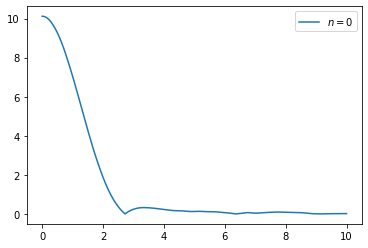

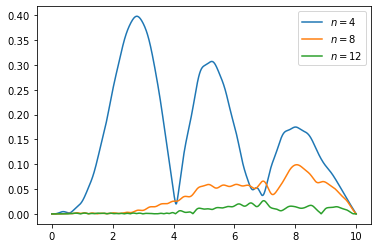

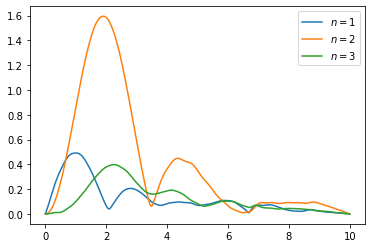

In [10]:
d = np.linspace(0, a, 1000, endpoint = True)

plt.plot(d, np.abs(g_n(0, d)), label = u'$n = %.f$' %0)
plt.legend(loc = 'best')

plt.show()

for k in [4, 8, 12]:
    plt.plot(d, np.abs(g_n(k, d)), label = u'$n = %.f$' %k)
    plt.legend(loc = 'best')

plt.show()

for k in [1, 2, 3]:
    plt.plot(d, np.abs(g_n(k, d)), label = u'$n = %.f$' %k)
    plt.legend(loc = 'best')

plt.show()

## Calculamos $K_n(\rho)$

In [11]:
def K_n(k, p):
    return g_n(k, p) * np.pi / (2 * a**2 * (1j)**k)

## Táboas de $K_n(\rho)$

In [12]:
radius_length = int((a + 0.5) / 0.01) + 1
radius = np.flip(np.linspace(a, 0, radius_length, endpoint = False))

if Table_K:
    K_n_loaded = np.zeros((2 * max_in_sum_2 + 1, radius_length), dtype = 'complex')

    for k in tqdm(np.arange(-max_in_sum_2, max_in_sum_2 + 1)):
        for j in range(radius_length):
            K_n_loaded[k + max_in_sum_2, j] = K_n(k, radius[j])

    np.savetxt('Results/Table_K_n_a_' + str(a) + '_' + boundary + '.txt', K_n_loaded)
    
else:
    K_n_loaded = np.loadtxt('Results//Table_K_n_a_' + str(a) + '_' + boundary + '.txt', dtype = 'complex')

## Calculamos $K(\rho, \beta)$

In [13]:
def find_nearest(array, value): # It returns the position.
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return int(idx)

def K_rho_beta(p, beta):
    _aux_ = 0 + 1j*0
    
    for k in np.arange(- max_in_sum_2, max_in_sum_2 + 1):
        idx = find_nearest(radius, p)
        _aux_ += K_n_loaded[k + max_in_sum_2, idx] * np.exp(1j * k * beta)
    
    return _aux_

## Discretizamos

A continuación discretizamos a antena para calcular as excitacións usando o método de valor media dos vértices do cadrado.

In [14]:
I_mn = []
I_x = []
I_y = []

sign_x = np.array([1, 1, -1, -1])
sign_y = np.array([1, -1, 1, -1])

limit = (np.int(a / spacing_dipoles) + 0.5) * spacing_dipoles

for y in tqdm(np.arange(- limit, limit + 1, spacing_dipoles)):        
    for x in np.arange(- limit, limit + 1, spacing_dipoles):
        r_ij = np.sqrt(x**2 + y**2)
        beta_ij = np.arctan2(y, x)
        m = int(1800 + round(10 * degrees(beta_ij)))

        if r_ij <= radio_vector[m]:
            aux = 0 + 1j*0

            for i in range(4):
                new_x = x + sign_x[i] * spacing_dipoles * 0.5
                new_y = y + sign_y[i] * spacing_dipoles * 0.5

                r_ij = np.sqrt(new_x**2 + new_y**2)
                beta_ij = np.arctan2(new_y, new_x)
                aux += K_rho_beta(r_ij, beta_ij)

            I_mn.append(0.25 * aux)
            I_x.append(x)
            I_y.append(y)

I_mn /= np.max(I_mn)

# Como método de optimización eliminamos os elementos con excitación menor á establecida.

excitation_threeshold = 0.02
removable_elements = np.where(np.abs(I_mn) < excitation_threeshold)[0]

I_mn = np.delete(I_mn, removable_elements)
I_x = np.delete(I_x, removable_elements)
I_y = np.delete(I_y, removable_elements)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:09<00:00,  4.49it/s]


## Calculamos $F(\theta, \phi)$

In [15]:
def f_subarray(u, v):
    if Subarray:
        psi_x = 2 * np.pi * spacing_subarray * u
        psi_y = 2 * np.pi * spacing_subarray * v
        return np.sin(0.5 * M * psi_x) * np.sin(0.5 * N * psi_y) / (np.sin(0.5 * psi_x) * np.sin(0.5 * psi_y))
    else:
        return 1

def f_element(u, v):
    if Element:
        return np.sin(0.5 * np.pi * np.sqrt(1 - u**2 - v**2)) * np.cos(2 * np.pi * 0.495 * u) / np.sqrt(1 - u**2)
    else:
        return 1

def F_theta_phi(u, v):
    F = 0 + 1j*0
    
    for k in range(len(I_mn)):
        exponent = 2 * np.pi * (I_x[k] * u + I_y[k] * v)
        F += I_mn[k] * np.exp(1j * exponent)
        
    return F * f_subarray(u, v) * f_element(u, v)

Creamos o enreixado.

In [16]:
x = np.linspace(- 1, 1, 361, endpoint = True); x[np.where(x == 0)] = 1e-5
X, Y = np.meshgrid(x, x)
len_x = len(x)

out_arg = np.where(X**2 + Y**2 >= 1)

X[out_arg] = 0.5
Y[out_arg] = 0.5

Calculamos os valores do patrón, limpámolo e xeramos a imaxe.

In [17]:
limit = -50

Z = np.abs(F_theta_phi(X, Y))
Z = 2 * pass_to_dB(Z)
clear_around(Z, limit)
Z = np.reshape(Z, (len_x, len_x))


for i in range(len_x):
    for j in range(len_x):
        x_0 = i * np.pi/len_x - np.pi/2
        y_0 = j * np.pi/len_x - np.pi/2
        
        if np.square(x_0*x_0 + y_0*y_0) > np.pi/2:
            Z[i, j] = limit

Xeramos a imaxe e gardamos resultados.

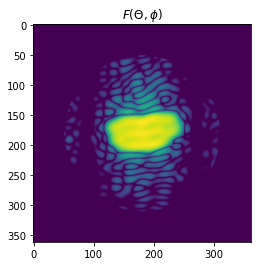

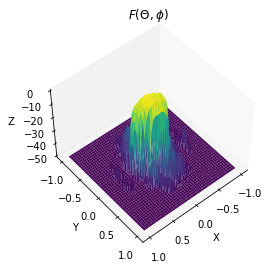

In [18]:
np.savetxt('Results/Data_F_' + boundary + '.txt', Z)

fig = plt.figure(1)
plt.imshow(Z) 
plt.title('$F(\Theta, \phi)$')
plt.savefig('Results/Horizontal_F_' + boundary + '.png', dpi = 300)

fig = plt.figure(2)
ax = plt.axes(projection = '3d')
X_plot, Y_plot = np.meshgrid(x, x)
ax.plot_surface(X_plot, Y_plot, Z, cmap = 'viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.grid(False)
ax.set_visible(True)
ax.set_zlim(limit, 0)
plt.title('$F(\Theta, \phi)$')
plt.savefig('Results/3D_F_' + boundary + '.png', dpi = 300)
ax.view_init(50, 50)

## Ratio de rango dinámico

In [19]:
def dynamic_range_ratio(array):
    array = np.abs(array)
    return np.max(array) / np.min(array)

print('O rango dinámico é de: ', dynamic_range_ratio(I_mn))

O rango dinámico é de:  49.79156151125476


In [20]:
print('Total execution time is:', np.round(time.perf_counter() - t0, 2), 's')

Total execution time is: 21.85 s
